https://github.com/MainakRepositor/Data-Analysis/blob/master/Hotel_Reviews_Sentiment_Prediction.ipynb
https://medium.com/@nutanbhogendrasharma/sentiment-analysis-for-hotel-reviews-with-nltk-and-keras-ce5cf3db39b
https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews
https://www.kaggle.com/code/lunamcbride24/hotel-review-keras-classification-project


# Import necessary library

In [1]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shienashabrina","key":"07875990a9fd6717dc7ac1ee3cf3b865"}'}

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import seaborn as sns


import numpy as np 
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

import random as rn

import re
print("Necessary packages have been included successfully!")

Necessary packages have been included successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
od.download(
    "https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews")

100%|██████████| 5.14M/5.14M [00:00<00:00, 7.65MB/s]


# Check dataset generally

In [5]:
#Load data into pandas
dfh = pd.read_csv('trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
dfh.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
# check column and rating 
ratings,columns = dfh.shape
print("Number of ratings in the dataset = ",ratings)
print("Number of columns in the dataset = ",columns)

Number of ratings in the dataset =  20491
Number of columns in the dataset =  2


In [7]:
# check if there is null or odd value
print(dfh.isnull().any())
print(dfh["Rating"].value_counts())
print(dfh.loc[dfh["Review"] == ""])

Review    False
Rating    False
dtype: bool
5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64
Empty DataFrame
Columns: [Review, Rating]
Index: []


Text(0.5, 1.0, 'Count of ratings \n')

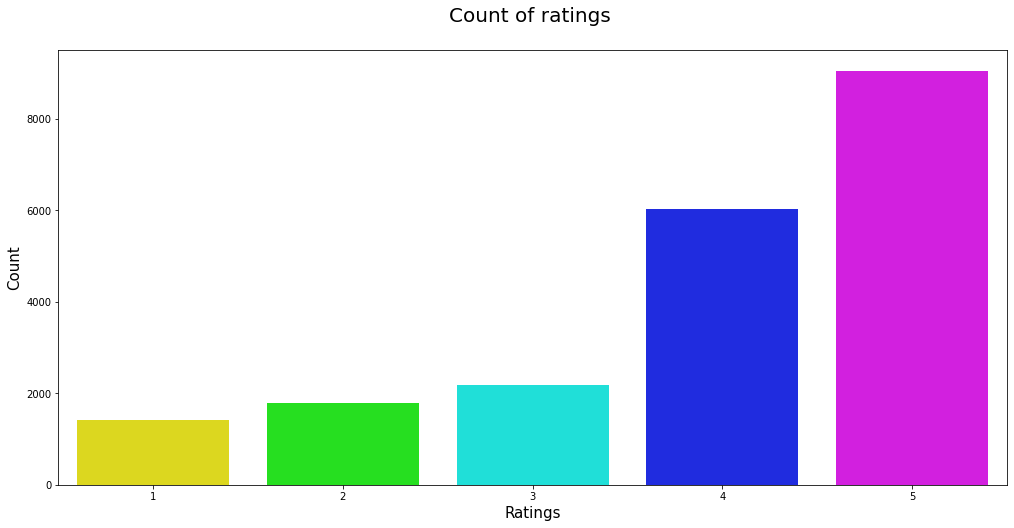

In [8]:
plt.figure(figsize=(17,8))
sns.countplot(x='Rating',data=dfh,palette='hsv')
plt.xlabel('Ratings',size=15)
plt.ylabel('Count',size=15)
plt.title("Count of ratings \n",size=20)

In [9]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1600, height = 600,
                          background_color ='#064420',
                          min_font_size = 8
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (18, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()

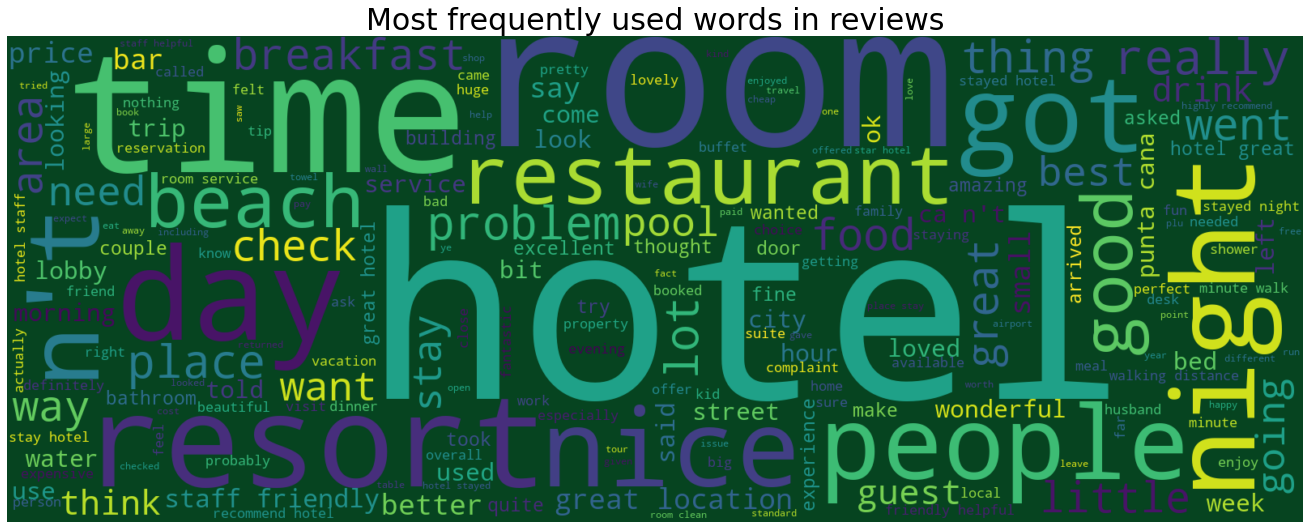

In [10]:
wordCloud_generator(dfh['Review'], title="Most frequently used words in reviews")

We figured there is zero missing value so no data clean needed. In rgeards for rating, everything look normal wih positive rating being the highest. Along with room, resort, hotel as the most used word.

# Deep cleaning for punctuation

In [11]:
# To check off the structure, print a random review
print(dfh["Review"][30])

good choice seattle stayed night business booked company, overall satisfactory arrived late evening room 17th floor clean comfortable great view, bathroom little small clean equipped, good night sleep enjoyed excellent breakfast restaurant checking, staff encountered friendly polite,  


Although no unusual reviews have been detected, additional punctuation may jeopardize the modeling process, so it is best to remove it

In [12]:
punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â"""

def reviewParse(review):
    splitReview = review.split() #Split the review into words
    parsedReview = "".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview])
    return parsedReview

dfh["CleanReview"] = dfh["Review"].apply(reviewParse)
dfh.head()

,Review,Rating,CleanReview
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4 experience hotel monaco seatt...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...


## Tokenizing

In [14]:
review = dfh["CleanReview"].copy()
print("Example Sentence: ") 
print(review[30])

token = Tokenizer()
token.fit_on_texts(review)
texts = token.texts_to_sequences(review)
print("Into a Sequence: ")
print(texts[30])

texts = pad_sequences(texts, padding='post')
print("After Padding: ")
print(texts[30])

Example Sentence: 
good choice seattle stayed night business booked company overall satisfactory arrived late evening room 17th floor clean comfortable great view bathroom little small clean equipped good night sleep enjoyed excellent breakfast restaurant checking staff encountered friendly polite 
Into a Sequence: 
[6, 215, 520, 15, 19, 218, 68, 960, 142, 3178, 100, 236, 190, 2, 3364, 51, 20, 52, 4, 50, 42, 32, 31, 20, 1101, 6, 19, 299, 123, 35, 22, 40, 590, 7, 1183, 30, 574]
After Padding: 
[  6 215 520 ...   0   0   0]


# Label Encoding

In [16]:
def encodeLabel(label):
    if label == 5 or label == 4:
        return 2
    if label == 3:
        return 1
    return 0

labels = ["Negative", "Neutral", "Positive"]
dfh["EncodedRating"] = dfh["Rating"].apply(encodeLabel)
dfh.head()

,Review,Rating,CleanReview,EncodedRating
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,2
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4 experience hotel monaco seatt...,1
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,2
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,2


# Split the data for training and testing

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, dfh["EncodedRating"], test_size=0.33, random_state=24)

In [19]:
size = len(token.word_index) + 1
ratings = dfh["EncodedRating"].copy()

tf.keras.backend.clear_session()

In [22]:
size = len(token.word_index) + 1
ratings = dfh['Rating'].copy()

tf.keras.backend.clear_session() 
epoch = 2
batchSize = 32
outputDimensions = 16
units = 256

model = tf.keras.Sequential([ 
    L.Embedding(size, outputDimensions, input_length = texts.shape[1]), 
    L.Bidirectional(L.LSTM(units, return_sequences = True)), 
    L.GlobalMaxPool1D(),
    L.Dropout(0.3), 
    L.Dense(64, activation="relu"),
    L.Dropout(0.3),
    L.Dense(3)
])

In [23]:
model.compile(loss = SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'adam', metrics = ['accuracy']
             )

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1931, 16)          1303776   
                                                                 
 bidirectional (Bidirectiona  (None, 1931, 512)        559104    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [25]:
history = model.fit(X_train, y_train, epochs=epoch, validation_split = 0.2, batch_size = batchSize)

Epoch 1/2
344/344 [==============================] - 83s 215ms/step - loss: 0.6474 - accuracy: 0.7673 - val_loss: 0.4739 - val_accuracy: 0.8321
Epoch 2/2
344/344 [==============================] - 71s 206ms/step - loss: 0.3886 - accuracy: 0.8533 - val_loss: 0.4050 - val_accuracy: 0.8562


# Make predictions

In [26]:
predict = np.argmax(model.predict(X_test),axis=1)
loss, accuracy = model.evaluate((X_test), (y_test))

#Print the loss and accuracy
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

212/212 [==============================] - 17s 81ms/step - loss: 0.4140 - accuracy: 0.8442
Test Loss:  0.41398197412490845
Test Accuracy:  0.84415203332901


In [27]:
print('Accuracy: {}'.format(accuracy_score(predict, y_test)))
print("Mean absolute error: {}".format(mean_absolute_error(predict,y_test)))
print("Root mean square error: {}".format(np.sqrt(mean_squared_error(predict,y_test))))

Accuracy: 0.844152003548721
Mean absolute error: 0.19547538074818868
Root mean square error: 0.5241470684283258


In [28]:
print(classification_report(y_test, predict, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.66      0.84      0.74      1061
     Neutral       0.35      0.07      0.11       742
    Positive       0.90      0.96      0.93      4960

    accuracy                           0.84      6763
   macro avg       0.64      0.62      0.60      6763
weighted avg       0.81      0.84      0.81      6763

